# Example 1: Exploration, Linear Trend, Fourier Transform & SARIMA

### Introduction

This notebook showcases several exploratory techniques and how to aggregate (sort of; add really) three different univariate models to capture three different types of patterns in a time series and combine their predictions to one forecast.

These three models are:
* A linear trend model (if you want to count that as a proper forecasting model) to capture a general trend
* A Fourier Transform model to capture yearly seasonality
* A SARIMA model to capture weekly seasonality

### Dataset

The dataset used here is a relatively simple and clean (and probably synthetic) dataset from Kaggle's [Store Item Demand Forecasting Challenge](https://www.kaggle.com/c/demand-forecasting-kernels-only). This dataset consists of 5 years of product by date, store, and item. It , making it ideal for demonstrating univariate time series analysis techniques.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX

from lineartrend import LinearTrend   
from fourierwave import FourierWave
import tshelper as h

plt.style.use("seaborn-whitegrid")

## Load and explore data

In [2]:
# Load data
df = pd.read_csv('data/demand_forecasting_train.csv', index_col="date")

# Convert index to PeriodIndex
df.index = pd.to_datetime(df.index).to_period("D")
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [3]:
# 913000 observations 
len(df)

913000

In [4]:
# 5 full years
df.index[0], df.index[-1]

(Period('2013-01-01', 'D'), Period('2017-12-31', 'D'))

In [5]:
# 10 stores in the dataset
df["store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [6]:
# 50 products in the dataset
df["item"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int64)

In [7]:
# Generate a time series: Sales of item 1 by date over all stores 
y = df.loc[df["item"] == 1] 
y = y["sales"].groupby(y.index).sum()

In [8]:
# No missing dates in the series
print(len(y))
gapless_index = pd.period_range(df.index[0], df.index[-1], freq="D")
print(len(gapless_index))

1826
1826


## Train/test split

In [9]:
y_train = y[:"2016"]
y_test = y["2017"]

## Exploratory analysis

### Summary statistics

In [10]:
# Summary statistics
y_train.describe()

count    1461.000000
mean      213.026010
std        54.416903
min        84.000000
25%       173.000000
50%       211.000000
75%       250.000000
max       387.000000
Name: sales, dtype: float64

### Visual analysis

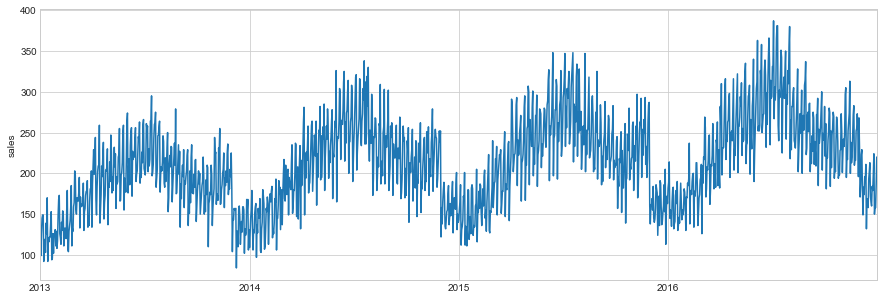

In [11]:
# Visualize time series
h.plot_series(y_train, ylabel=y.name)

An upward trend and yearly seasonality resembling a sine wave are visible.

Resampling the series to weekly data or calculating rolling means provides a less noisy picture of the longer-term seasonalities:

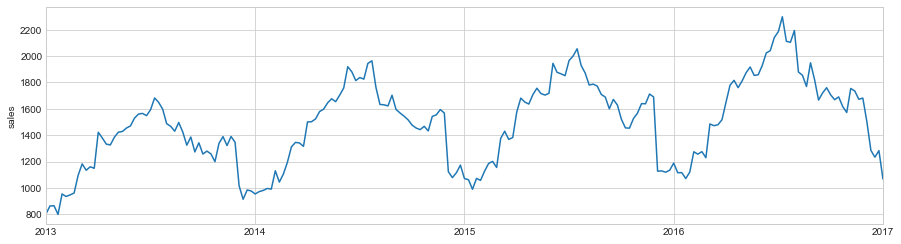

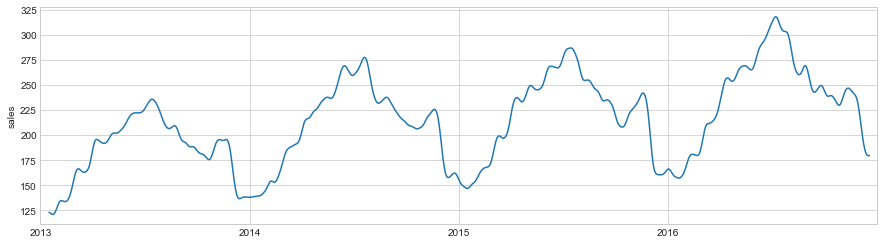

In [12]:
# Resample series to weekly data
h.plot_series(y_train.resample("W").sum(), ylabel=y.name, figsize=(15,4))

# Gaussian rolling mean (window = 30, standard deviation = 10)
y_train_rm = y_train.rolling(30, center=True, win_type="gaussian").mean(std=5)
h.plot_series(y_train_rm, ylabel=y.name, figsize=(15,4))

Upsampling or rolling means show that there appears to be a spike in sales each year in the Christmas season.

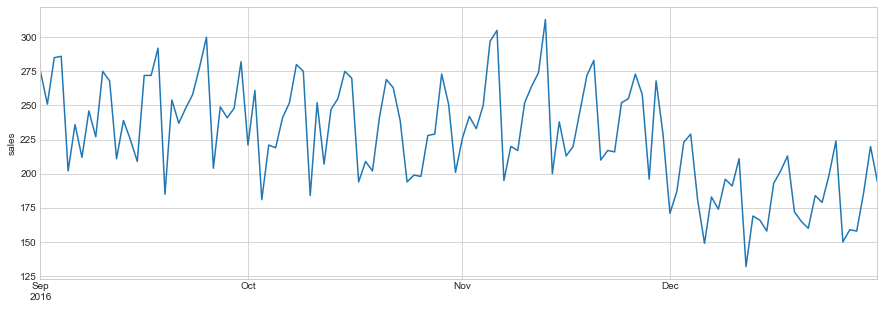

In [13]:
# Visualize time series: 4-month slice
h.plot_series(y_train["2016-09":], ylabel=y.name)

# >> weekly seasonality

Looking at just 4 months of the data reveals a weekly pattern with sales being lowest on Sundays.

### Seasonal decomposition

Performing a seasonal decomposition confirms this picture: A pretty stable upwards trend and clear yearly and weekly seasonality is visible.

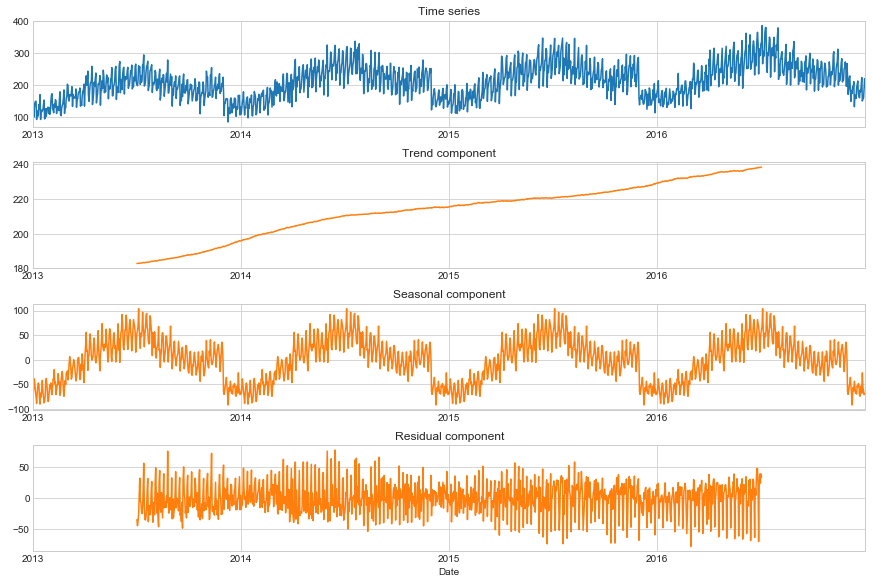

In [15]:
# Visualize seasonal decomposition
h.plot_seasonal_decompose(y_train, freq=365)

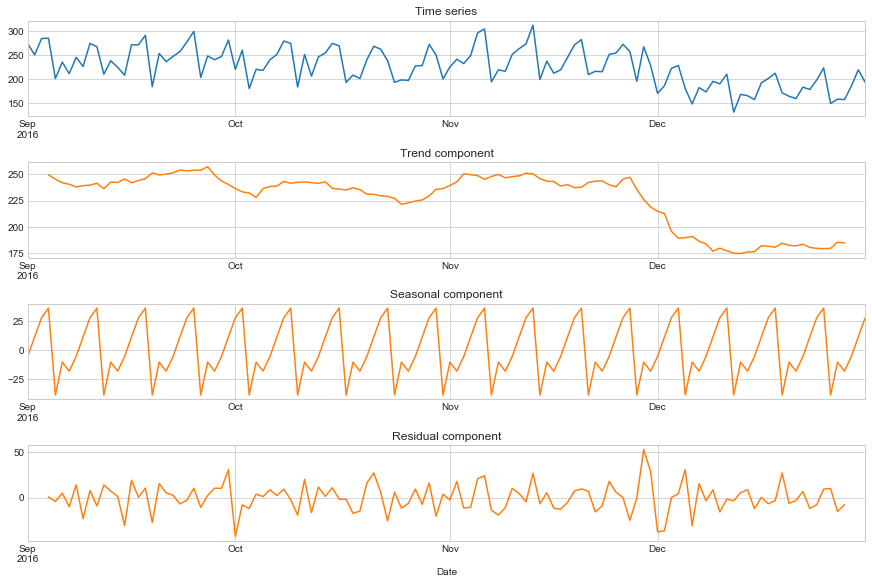

In [17]:
# Visualize seasonal decomposition: 4-month slice
h.plot_seasonal_decompose(y_train["2016-09":],freq=7)

# >> weekly seasonality

### Autocorrelation

The first autocorrelation and partial autocorrelation plot pair with daily data shows that autocorrelation exists with a weekly pattern. The second pair with aggregated monthly data shows the yearly pattern again.

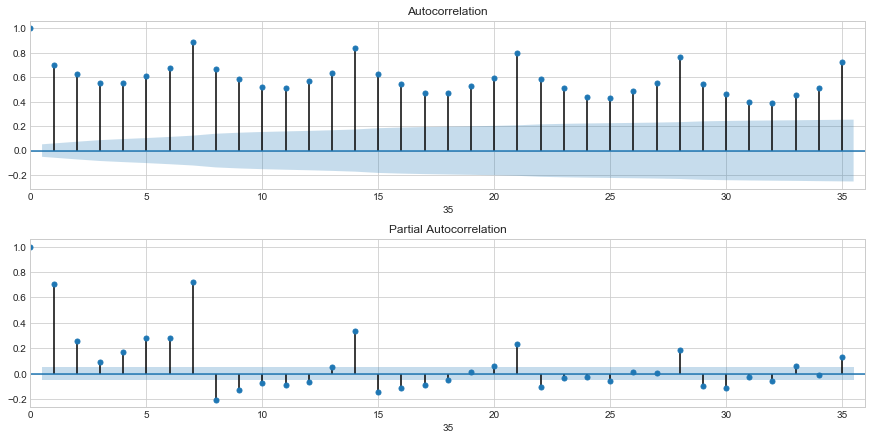

In [19]:
# Show ACF and PAFC plots
h.plot_acf_pacf(y_train, lags=35, figsize=(12,6))

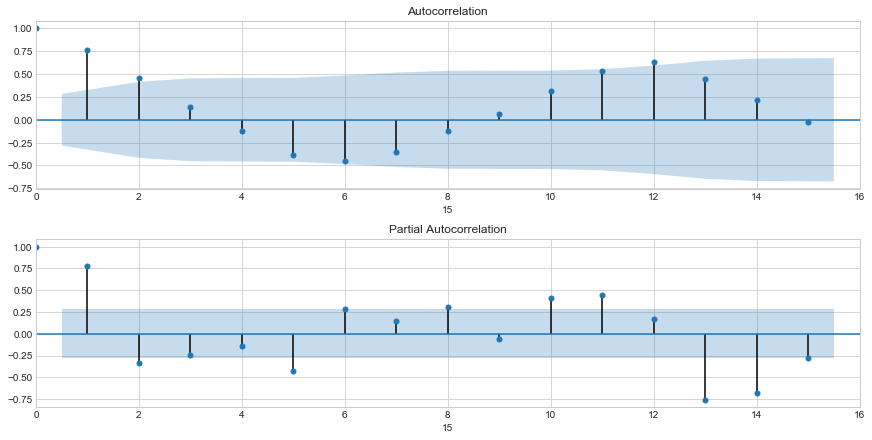

In [20]:
# Show ACF and PAFC plots - resampled to monthly data
h.plot_acf_pacf(y_train.resample("M").sum(), lags=15, figsize=(12,6))

### t-tests

Is there really sales spike in the Christmas season?

In [21]:
# One-sample t-test: Is December different from other months?
stats.ttest_1samp(y_train[y_train.index.month >= 11], popmean=y_train.mean())

Ttest_1sampResult(statistic=-6.973366074007222, pvalue=2.9084026729183122e-11)

Yes, the p-value is zero.

## Linear trend

Step 1: Capturing the linear trend with a simple linear regression model.

R-squared:               0.0641
Root mean squared error: 56.6031
Mean absolute error:     46.3808


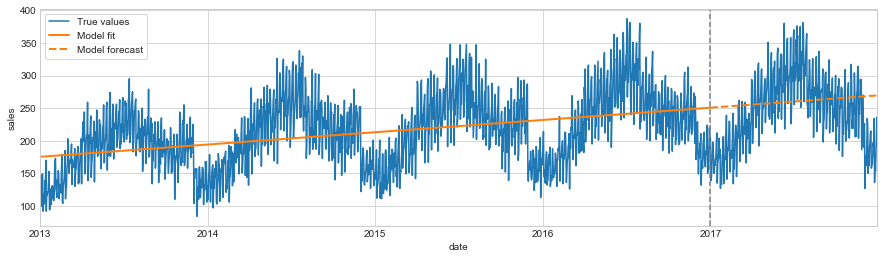

In [22]:
# Instantiante and train model
trend_model = LinearTrend(y=y_train)
trend_model.fit_ts()

# Predict and forecast
y_pred = trend_model.predict_ts()
y_fcst = trend_model.forecast_ts(steps=365)
y_trend = y_pred.append(y_fcst)

# Generate de-trended time series (= residuals)
y_dt = y - y_trend

# Evaluate model on test set
h.eval_model(y_test, y_fcst)

# Visualize prediction and forecast
h.plot_model(y, y_pred, y_fcst, xlabel=y.index.name, ylabel=y.name)

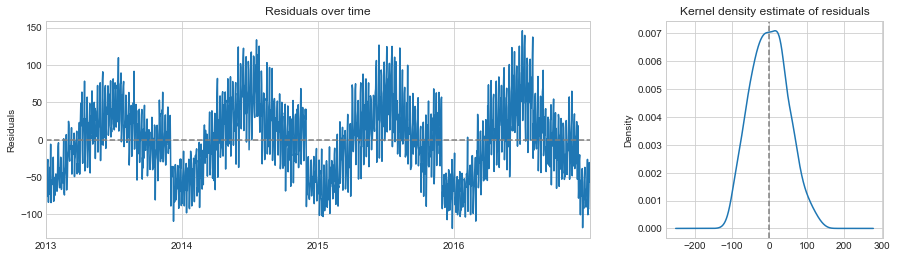

In [24]:
# Visualize residuals
h.plot_residuals(residuals=y_dt[y_train.index])

The residuals are centered around zero, but there's (of course) still a clear pattern in the time series that the model didn't capture.

# Fourier Transform

Step 2: Capturing yearly seasonality with a Fourier Transform model.

In [25]:
# Train/test split
y_train = y_dt[y_train.index]
y_test = y_dt[y_test.index]

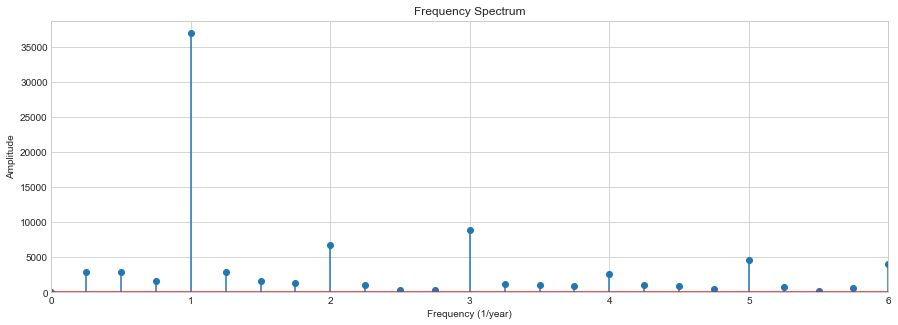

In [26]:
# Instantiate FourierWave class
wave_model = FourierWave(y=y_train, freq="D")

# Apply Fourier Transform
wave_model.transform()

# Visualize frequency domain spectrum
wave_model.plot_spectrum()

There is a big spike (i.e. a large amplitude) at index 4 (annual frequency) and additional smaller spikes at indices 2, 3, 5, and 6 (semi-annual, 1/3 yearly and 1/5 yearly, and bi-monthly frequencies, respectively).

There more frequencies are selected for applying the transform, the better the model fits to the training data, but the higher the risk of overfitting is. I select just 4 frequencies below.

In [27]:
# Select frequencies for the Transform
frequency_indices = [4, 8, 12, 16]

# Fit model
wave_model.fit(frequency_indices=frequency_indices)

# Show (frequency, amplitude, angle) tuples used to fit the model
for tpl in (wave_model.freq_amp_angle_ls):
    print("Frequency: {:.4f} | Amplitude: {:.2f} | Angle: {:.2f}".format(tpl[0], tpl[1], tpl[2]))

Frequency: 0.0027 | Amplitude: 36918.05 | Angle: 3.07
Frequency: 0.0055 | Amplitude: 6731.57 | Angle: 1.77
Frequency: 0.0082 | Amplitude: 8820.27 | Angle: 2.57
Frequency: 0.0110 | Amplitude: 2584.22 | Angle: -2.23


R-squared:               0.5304
Root mean squared error: 37.9811
Mean absolute error:     31.3440


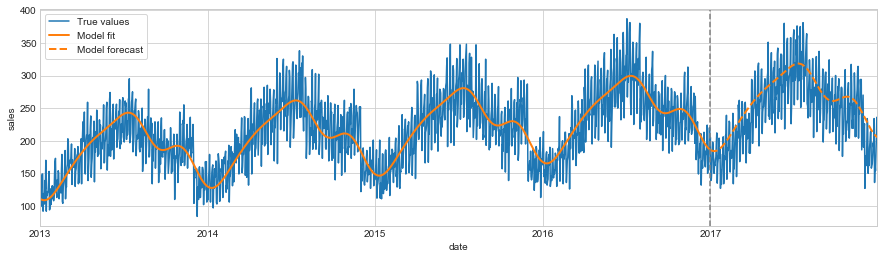

In [28]:
# Predict and forecast
y_pred = wave_model.predict()
y_fcst = wave_model.forecast(steps=365)

# Add wave to trend
y_trend_wave = y_trend + y_pred.append(y_fcst)

# Generate de-trended and "de-waved" time series (= residuals)
y_dt_dw = y - y_trend_wave

# Evaluate model
h.eval_model(y[y_test.index], y_trend_wave[y_test.index])

# Visualize model performance
h.plot_model(y, y_trend_wave[y_train.index], y_trend_wave[y_test.index],
             xlabel=y.index.name, ylabel=y.name)

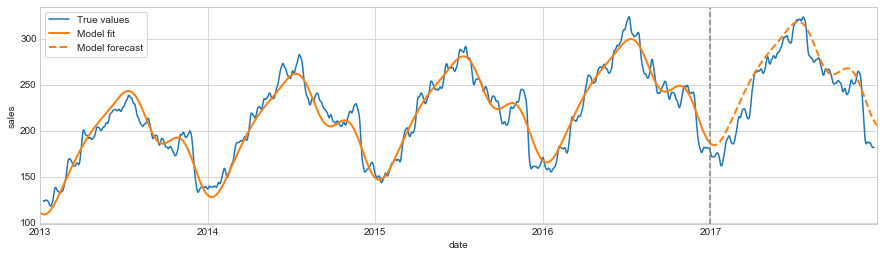

In [29]:
# Visualize model performance - clearer picture with rolling mean
y_rm = y.rolling(15, center=True, win_type="gaussian").mean(std=3)
h.plot_model(y_rm, y_trend_wave[y_train.index], y_trend_wave[y_test.index],
             xlabel=y.index.name, ylabel=y.name)

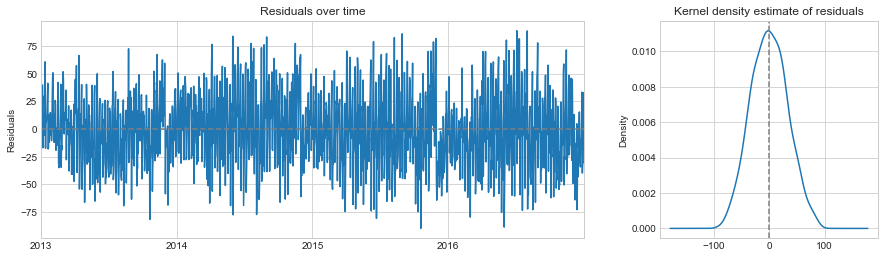

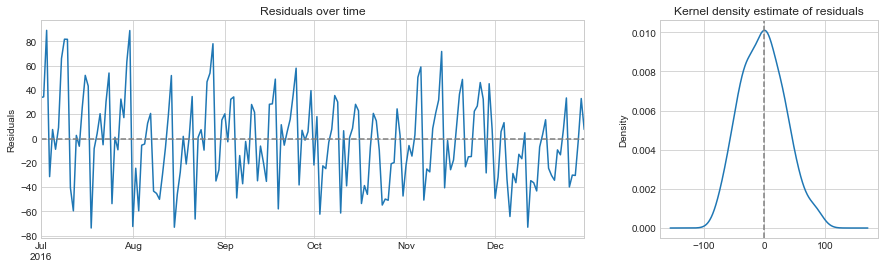

In [31]:
# Visualize residuals
h.plot_residuals(residuals=y_dt_dw[y_train.index])

# Visualize residuals - 4-month slice only
h.plot_residuals(residuals=y_dt_dw["2016-07":"2016-12"])

* The model with 4 cosine waves manages to fit the time series already relatively well. Compared to just the linear trend model, R² is much higher and the mean errors went down a bit as well. 
* However, it doesn't capture the weekly seasonality (of course), and 'under-estimates' the Christmas spike.
* The forecast also overestimates daily sales in the test year a bit - because the overall trend is not perfectly linear. Sales grow a bit slower in the test year.

# SARIMA

Step 3: Capturing weekly seasonality with a SARIMA model.

In [32]:
# Train/test split
y_train = y_dt_dw[y_train.index]
y_test = y_dt_dw[y_test.index]

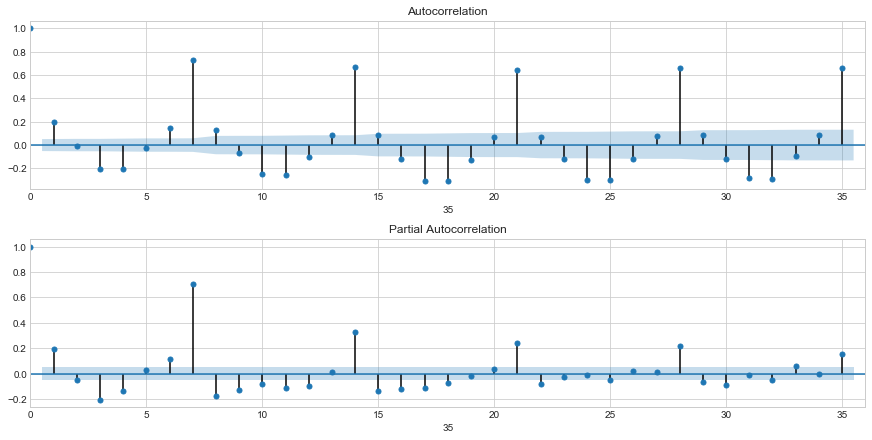

In [34]:
# ACF and PAFC plots of the residuals from the previous two models 

h.plot_acf_pacf(y_dt_dw[y_train.index], lags=35, figsize=(12,6))

# ar(4)
# weekly seasonality with 7+ lags

* The ACF and PACF plots show weekly seasonality (autoregressive processes with multiples of 7). Other than that an AR(4) process is still significant.
* I'll train a SARIMA(4,1,2)(4,1,2)7 model: (AR(4),I(1),MA(2) + seasonal(AR(4),I(1),MA(2)) with weekly seasonality.
* With some tuning one could find a (slightly) better combination, but that's not relevant here.

In [35]:
# Instantiate and train model
sarima_model = SARIMAX(y_train, order=(4,1,2), seasonal_order=(4,1,2,7))
sarima_model = sarima_model.fit(maxiter=200)

# Model statistics
sarima_model.summary()

C:\Users\chris\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1461
Model:             SARIMAX(4, 1, 2)x(4, 1, 2, 7)   Log Likelihood               -6255.248
Date:                           Sat, 16 Nov 2019   AIC                          12536.496
Time:                                   16:32:56   BIC                          12605.154
Sample:                               01-01-2013   HQIC                         12562.115
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7583      0.153      4.953      0.000       0.458       1.058
ar.L2          0.0270      0.044      0.613      0.540      -0.059       0.113
ar.L3         -0.0257      0.039     -0.656      0.512      -0.102       0.051
ar.L4          0.0617      0.036      1.693      0.091      -0.010       0.133
ma.L1         -1.5414      0.153    -10.091      0.000      -1.841      -1.242
ma.L2          0.5419      0.151      3.588      0.000       0.246       0.838
ar.S.L7        0.7751      0.143      5.419      0.000       0.495       1.055
ar.S.L14      -0.0340      0.034     -0.988      0.323      -0.101       0.033
ar.S.L21      -0.0121      0.033     -0.368      0.713      -0.077       0.052
ar.S.L28       0.0704      0.032      2.208      0.027       0.008       0.133
ma.S.L7       -1.6470      0.142    -11.625      0.000      -1.925      -1.369
ma.S.L14       0.6516      0.138      4.718      0.000       0.381       0.922
sigma2       315.0651     11.472     27.464      0.000     292.580     337.550
===================================================================================
Ljung-Box (Q):                       44.17   Jarque-Bera (JB):                13.46
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Model interpretation:
* Only the first autoregressive term (ar.L1) is statistically significant at the 95% confidence level
* Both moving average terms (ma.L1 and ma.L2) are significant
* Only the first and fourth seaonal autoregressive terms (ar.S.L7 and ar.S.L14) are statistically significant
* Both seasonal moving average terms (ma.S.L7 and ma.S.L14) are significant

R-squared:               0.7317
Root mean squared error: 21.1701
Mean absolute error:     17.0914


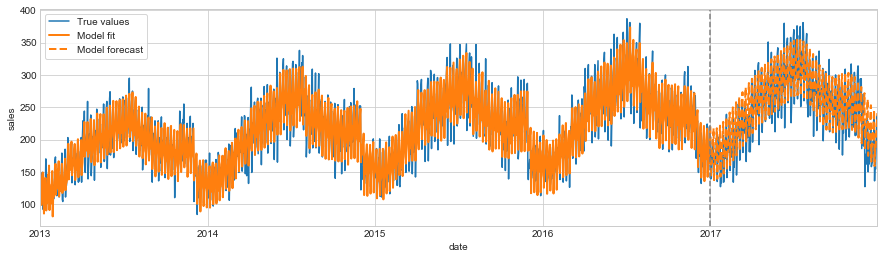

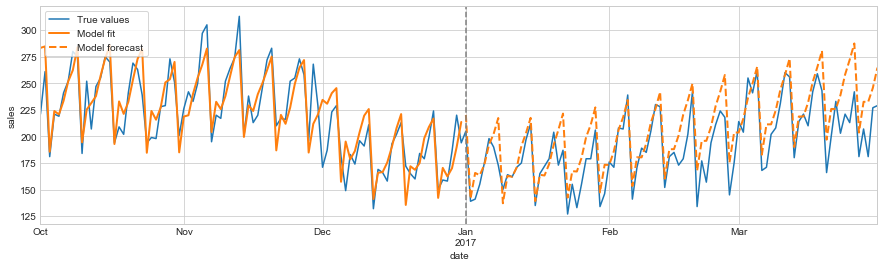

In [36]:
# Predict and forecast
y_pred = sarima_model.predict()
y_fcst = sarima_model.forecast(365)
y_trend_wave_sarima = y_trend_wave + y_pred.append(y_fcst)

# Generate de-trended, "de-waved", "de-sarimaed" time series
y_dt_dw_ds = y - y_trend_wave_sarima

# Evaluate model on test set
h.eval_model(y[y_test.index], y_trend_wave_sarima[y_test.index])

# Visualize fit and forecast
h.plot_model(y, y_trend_wave_sarima[y_train.index], y_trend_wave_sarima[y_test.index], 
             xlabel=y.index.name, ylabel=y.name)

# Visualize fit and forecast - 6-month slice of the training and test data
h.plot_model(y["2016-10":"2017-03"], y_trend_wave_sarima["2016-10":"2016-12"], y_trend_wave_sarima["2017-01":"2017-03"], 
             xlabel=y.index.name, ylabel=y.name)

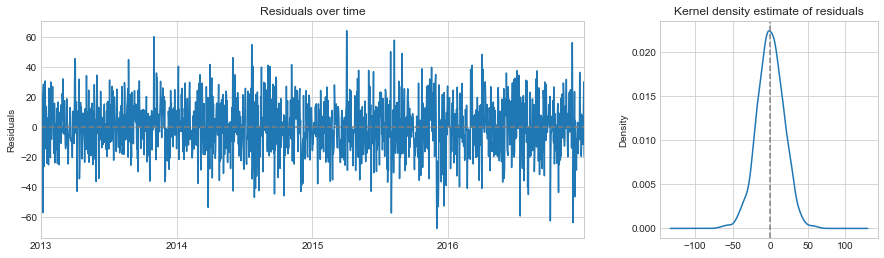

In [38]:
# Visualize residuals
h.plot_residuals(residuals=y_dt_dw_ds[y_train.index])

* Adding the SARIMA model to the other two improves the model fit again substantially: R² and mean errors for the test year go down quite a bit again
* The forecast for the test year is still a bit too optimistic, however.
* Residuals are centered around 0 and no clear pattern is visible anymore - that's good

## Visualize the different model predictions together

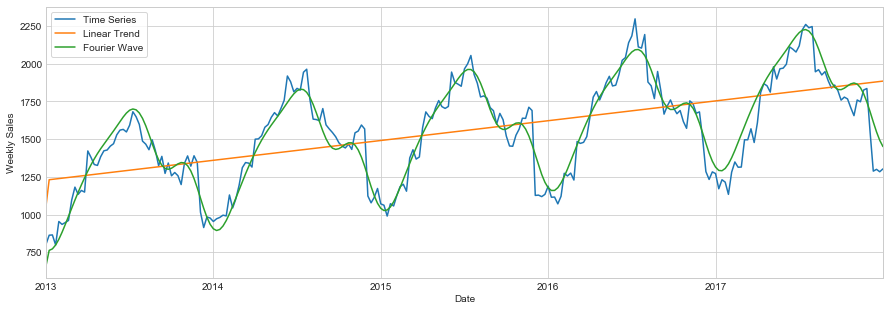

In [39]:
# Resampled time series: Weekly sales
h.plot_series(y.resample("W").sum().rename("Time Series"),
             y_trend.resample("W").sum().rename("Linear Trend"),
             y_trend_wave.resample("W").sum().rename("Fourier Wave"),
              xlabel="Date", ylabel="Weekly Sales")

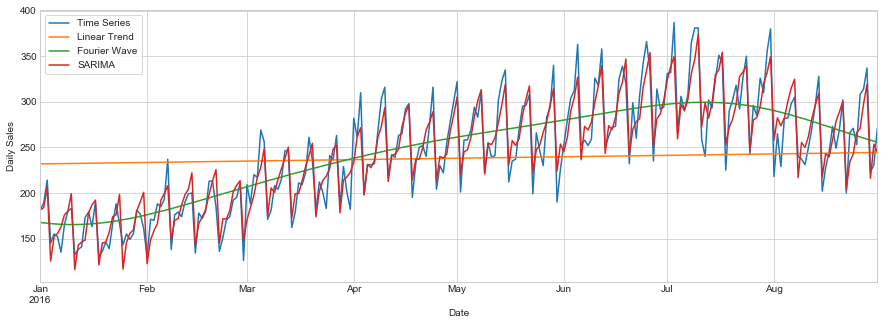

In [40]:
# Slice of time series: Daily sales
h.plot_series(y["2016-01":"2016-08"].rename("Time Series"),
             y_trend["2016-01":"2016-08"].rename("Linear Trend"),
             y_trend_wave["2016-01":"2016-08"].rename("Fourier Wave"),
            y_trend_wave_sarima["2016-01":"2016-08"].rename("SARIMA"),
              xlabel="Date", ylabel="Daily Sales")